<a href="https://colab.research.google.com/github/wayaadhyasta/PredictPerbankan_MachineLearning/blob/main/perbankan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import library for data

In [ ]:
import numpy as np # libarary untuk numerik
import re # untuk manipulasi teks menggunakan ekspresi reguler
import pandas as pd # manupulasi dan anilitis data
import seaborn as sns # untuk visiulisasi data
import matplotlib.pyplot as plt # untuk membuat plot/grafik
from sklearn.model_selection import train_test_split # fungsi untuk membagi dataset menjadi data latih dan data uji
from sklearn.feature_extraction.text import CountVectorizer # menggubah teks menjadi representasi numerik
from sklearn.neighbors import KNeighborsClassifier # Changed KNneighborsassifier to KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier # untuk import model algoritma random forest
from sklearn.naive_bayes import MultinomialNB # untuk import model naive bayes
from sklearn.svm import SVC # untuk support vector calssifier (SVM)
from sklearn.metrics import (classification_report, # laporan metrik evaluasi(precision, recall, f1-score)
                             accuracy_score, # mengghitung akurasi model
                             recall_score,  # menghitung recall model
                             precision_score, # menghitung precision model
                             f1_score, # Menghitung F1-score (rata-rata harmonik precision dan recall)
                             confusion_matrix)  # Membuat confusion matrix untuk melihat prediksi vs aktual
from collections import Counter  # Menghitung jumlah kemunculan elemen dalam suatu koleksi (fix kesalahan pada kode)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataPerbankan.csv')
df

,at,userName,content,score,application
0,2022-12-31 15:33:31,Miftah Assundawi,di update malah ngabisin pulsa buat verifikasi...,1,BCA
1,2022-12-31 09:31:31,muhamad maulana ahsan,udah scan dokumen sama scan wajah berulang kal...,1,BCA
2,2022-12-31 06:42:45,Lanjutkan Di Kita Official,adminnya jawaban selalu monoton mohon mengirim...,1,BCA
3,2022-12-31 05:59:59,Beizi Nakata,aplikasi ini menjadi gak guna masa mengenali w...,1,BCA
4,2022-12-31 03:45:08,Akhmad Supriyanto,di update malah nyusahinlogin beberapa kali te...,1,BCA
...,...,...,...,...,...
6165,2024-09-23 19:47:35,Alkarim Sukamti,tidak bisa dibukadisentuh jg tdk bisapdahal ba...,2,BRI
6166,2024-09-23 19:41:03,Setya Yiyin,sangat membantu dan mudah di gunakan dan efesi...,5,BRI
6167,2024-09-23 19:27:20,Kristop Hura,mantapp cepat tepat dan akurat,5,BRI
6168,2024-09-23 19:26:09,Oshin Bali,sangat mudah digunakan untuk transasi apapun t...,5,BRI


Preprocessing

In [ ]:
# Fungsi untuk memfilter baris dalam dataframe berdasarkan jumlah kata dalam kolom tertentu
def filter_tokens_by_length(dataframe, column, min_words, max_words):
    # Menghitung jumlah kata dalam setiap baris di kolom yang ditentukan
    words_count = dataframe[column].astype(str).apply(lambda x: len(x.split()))

    # Membuat mask (filter) untuk memilih baris dengan jumlah kata dalam rentang yang ditentukan
    mask = (words_count >= min_words) & (words_count <= max_words)

    # Menerapkan mask ke dataframe untuk mendapatkan data yang telah difilter
    filtered_df = dataframe[mask]
    return filtered_df

# Menentukan batas minimum dan maksimum jumlah kata
min_words = 3  # Minimal 3 kata dalam sebuah teks
max_words = 50  # Maksimal 50 kata dalam sebuah teks

# Memfilter dataframe `df` berdasarkan panjang teks dalam kolom 'content'
df = filter_tokens_by_length(df, 'content', min_words, max_words)


In [ ]:
columns_4 = df[['at','userName','score','application']]

In [ ]:
# Kamus normalisasi: daftar kata tidak baku dan padanannya dalam bahasa yang lebih baku
norm = {
    'kmna': 'mana',
    'bisa2': 'bisa',
    'ngga': 'tidak',
    'apK': 'aplikasi',
    'tdk': 'tidak',
    'gk': 'tidak',
    'profisional': 'profesional',
    'skrng': 'sekarang',
}

# Fungsi untuk melakukan normalisasi teks berdasarkan kamus `norm`
def normalisasi(str_text):
    # Looping untuk mengganti setiap kata dalam kamus `norm` dengan kata baku
    for i in norm:
        str_text = str_text.replace(i, norm[i])  # Mengganti kata tidak baku dengan yang baku
    return str_text  # Mengembalikan teks yang sudah dinormalisasi

# Menerapkan fungsi normalisasi pada setiap baris di kolom 'content'
df['content'] = df['content'].apply(lambda x: normalisasi(x))


<ipython-input-69-27b02e8a49ec>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(lambda x: normalisasi(x))


In [ ]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


membuang kata yang tidak berbobot atau tidak kata baku atau kata tidak penting

In [ ]:
# Import library Sastrawi untuk menghapus stopwords dalam bahasa Indonesia
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# List untuk menambahkan stopwords tambahan
more_stop_words = []

# Mengambil daftar stopwords bawaan dari Sastrawi
stop_words = StopWordRemoverFactory().get_stop_words()

# Menambahkan stopwords tambahan ke dalam daftar stopwords (saat ini masih kosong)
stop_words.extend(more_stop_words)

# Membuat array dictionary dengan daftar stopwords yang diperbarui
new_array = ArrayDictionary(stop_words)

# Membuat objek StopWordRemover baru dengan daftar stopwords yang telah diperbarui
stop_words_remover_new = StopWordRemover(new_array)

# Fungsi untuk menghapus stopwords dari teks
def stopword(str_text):
    str_text = stop_words_remover_new.remove(str_text)  # Menghapus stopwords dari teks
    return str_text

# Menerapkan fungsi stopword() ke setiap baris dalam kolom 'content'
df['content'] = df['content'].apply(lambda x: stopword(x))

# Menampilkan 5 sampel acak dari dataframe setelah stopwords dihapus
df.sample(5)


<ipython-input-70-9b24d5a2b9e2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['content'].apply(lambda x: stopword(x))


,content,at,userName,score,application,sentimen,year
4649,sangat puas layan terimakasih brimo moga makin...,2024-09-27 16:41:42,riski gea,5,BRI,positif,2024
3075,udah update tintidakat layan terus ktanya,2024-09-14 17:21:06,ichsan prasetyo,2,BNI,negatif,2024
3095,cepat tepat jelas,2024-09-14 09:33:33,Ram doni,5,BNI,positif,2024
1758,mbanking kemarin tgl 24 desember pagi pake tra...,2022-12-25 09:01:46,Krisna Damayanti N Z,1,BNI,negatif,2022
1286,hallo bca adakan beli emas cara cicil aplikasi...,2024-09-22 22:51:54,Maju mundor,5,BCA,positif,2024


In [ ]:
columns_4

,at,userName,score,application
0,2022-12-31 15:33:31,Miftah Assundawi,1,BCA
1,2022-12-31 09:31:31,muhamad maulana ahsan,1,BCA
2,2022-12-31 06:42:45,Lanjutkan Di Kita Official,1,BCA
3,2022-12-31 05:59:59,Beizi Nakata,1,BCA
4,2022-12-31 03:45:08,Akhmad Supriyanto,1,BCA
...,...,...,...,...
6165,2024-09-23 19:47:35,Alkarim Sukamti,2,BRI
6166,2024-09-23 19:41:03,Setya Yiyin,5,BRI
6167,2024-09-23 19:27:20,Kristop Hura,5,BRI
6168,2024-09-23 19:26:09,Oshin Bali,5,BRI


In [ ]:
# tokenize
tokenized = df['content'].apply(lambda x: x.split())
tokenized

,content
0,"[update, malah, ngabisin, pulsa, buat, verifik..."
1,"[udah, scan, dokumen, sama, scan, wajah, berul..."
2,"[adminnya, jawaban, selalu, monoton, mohon, me..."
3,"[aplikasi, menjadi, gak, masa, mengenali, waja..."
4,"[update, malah, nyusahinlogin, beberapa, kali,..."
...,...
6165,"[bisa, dibukadisentuh, jg, bisapdahal, baru, b..."
6166,"[sangat, membantu, mudah, gunakan, efesien, wa..."
6167,"[mantapp, cepat, tepat, akurat]"
6168,"[sangat, mudah, digunakan, transasi, apapun, t..."


untuk mengganti kata yg tidak berbobot jadi berbotot atau menjadi kata baku

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text_cleanning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for i in text_cleanning:
    dt = stemmer.stem(i)
    do.append(dt)
  d_clean = []
  d_clean = ' '.join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)

update malah ngabisin pulsa buat verifikasi lewat sms parah nih bca ribet verifikasi biasa lewat sms sekarang pake ktp sama wajah bikin lama aja mau masuk login nya bintang satuberbicara moga depan lebih baik
udah scan dokumen sama scan wajah ulang kali tetep gabisa dipake malah pentidakinian data cabang dekat makin ga efisien aja apk nya
adminnya jawab selalu monoton mohon kirim screenshoot email twiternya bca jawab udh suruh bank bca dekat baharu datalha apa guna aplikasi kalo ke kantor cabangalasannya dalih hindar tipu onlineyang dibenerkan aplikasi bukan nasabahnyaaplikasimu jelek di rubah
aplikasi jadi gak masa nali wajah milik nya gak sudah coba 3x gagal terus padahal surut moto ktp langsung terus verifikasi wajah tetep gagalbagusan bri mobile gak ribet sangat kecewa sekali aplikasi bca mobile
update malah nyusahinlogin beberapa kali tetep aja gak masukdi perifikasi wajah nya gagal terusmuntidakin banyak ngeluh tentang initolong koreksi lagiko bca jadi ribet sekarang
dulu sangat 

KeyboardInterrupt: 

In [ ]:
df = pd.concat([tokenized, columns_4], axis=1)
df

,content,at,userName,score,application
0,"[update, malah, ngabisin, pulsa, buat, verifik...",2022-12-31 15:33:31,Miftah Assundawi,1,BCA
1,"[udah, scan, dokumen, sama, scan, wajah, berul...",2022-12-31 09:31:31,muhamad maulana ahsan,1,BCA
2,"[adminnya, jawaban, selalu, monoton, mohon, me...",2022-12-31 06:42:45,Lanjutkan Di Kita Official,1,BCA
3,"[aplikasi, menjadi, gak, masa, mengenali, waja...",2022-12-31 05:59:59,Beizi Nakata,1,BCA
4,"[update, malah, nyusahinlogin, beberapa, kali,...",2022-12-31 03:45:08,Akhmad Supriyanto,1,BCA
...,...,...,...,...,...
6165,"[bisa, dibukadisentuh, jg, bisapdahal, baru, b...",2024-09-23 19:47:35,Alkarim Sukamti,2,BRI
6166,"[sangat, membantu, mudah, gunakan, efesien, wa...",2024-09-23 19:41:03,Setya Yiyin,5,BRI
6167,"[mantapp, cepat, tepat, akurat]",2024-09-23 19:27:20,Kristop Hura,5,BRI
6168,"[sangat, mudah, digunakan, transasi, apapun, t...",2024-09-23 19:26:09,Oshin Bali,5,BRI


labelling

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hasil_preprocessing.csv')
df.sample(15)

,content,at,userName,score,application
4149,kasih 3 bintang dulu selaku guna kartu kredit ...,2023-04-16 10:52:32,Bayu Kurniawan,3,BRI
1289,kenapa bca mobile tiba tiba keluar harus verif...,2024-09-22 20:59:40,Deni Setiadi,1,BCA
2011,di update malah bisa masuk aplikasi mau login ...,2022-09-11 02:15:23,wafda atqia,1,BNI
3907,saran catat uang mungkin isi tanggal isi otoma...,2022-08-10 22:15:20,Taufik Cahya,5,BRI
3633,saya enggk input nomor rekening daftar akun br...,2022-10-07 21:27:14,Ria Mustika,4,BRI
2735,mau buka rekening baru lalu online malah notif...,2023-04-16 02:53:01,Natalis Natal Eli Gulo,1,BNI
4396,aplikasi sangat bagus banyak fitur jadi mudah ...,2024-09-30 07:56:41,arif wibowo,5,BRI
4397,aplikasi brimo bagus sudah lengkap menu masih ...,2024-09-30 07:22:02,Zaenuri Doang,5,BRI
2125,tiap bulan harus upgrade trus sich tiap bulan ...,2022-07-21 23:31:54,Muha Rrim,2,BNI
4773,simple cepat,2024-09-26 07:59:58,Muhammad Solihin,5,BRI


In [ ]:
def label_sentimen(score):
  if score <= 2:
    return 'negatif'
  elif score ==3:
    return 'netral'
  else:
    return 'positif'

df['sentimen'] = df['score'].apply(label_sentimen)
df

,content,at,userName,score,application,sentimen
0,update malah ngabisin pulsa buat verifikasi le...,2022-12-31 15:33:31,Miftah Assundawi,1,BCA,negatif
1,udah scan dokumen sama scan wajah ulang kali t...,2022-12-31 09:31:31,muhamad maulana ahsan,1,BCA,negatif
2,adminnya jawab selalu monoton mohon kirim scre...,2022-12-31 06:42:45,Lanjutkan Di Kita Official,1,BCA,negatif
3,aplikasi jadi guna masa nali wajah milik nya b...,2022-12-31 05:59:59,Beizi Nakata,1,BCA,negatif
4,update malah nyusahinlogin beberapa kali tetep...,2022-12-31 03:45:08,Akhmad Supriyanto,1,BCA,negatif
...,...,...,...,...,...,...
4976,bisa dibukadisentuh bisapdahal baru buat brimo...,2024-09-23 19:47:35,Alkarim Sukamti,2,BRI,negatif
4977,sangat bantu mudah guna efesien waktu,2024-09-23 19:41:03,Setya Yiyin,5,BRI,positif
4978,mantapp cepat tepat akurat,2024-09-23 19:27:20,Kristop Hura,5,BRI,positif
4979,sangat mudah guna transasi apa trims brimo,2024-09-23 19:26:09,Oshin Bali,5,BRI,positif


In [ ]:
df_counts = df.sentimen.value_counts()
df_counts

,count
sentimen,
negatif,3135
positif,1375
netral,471


Visialization


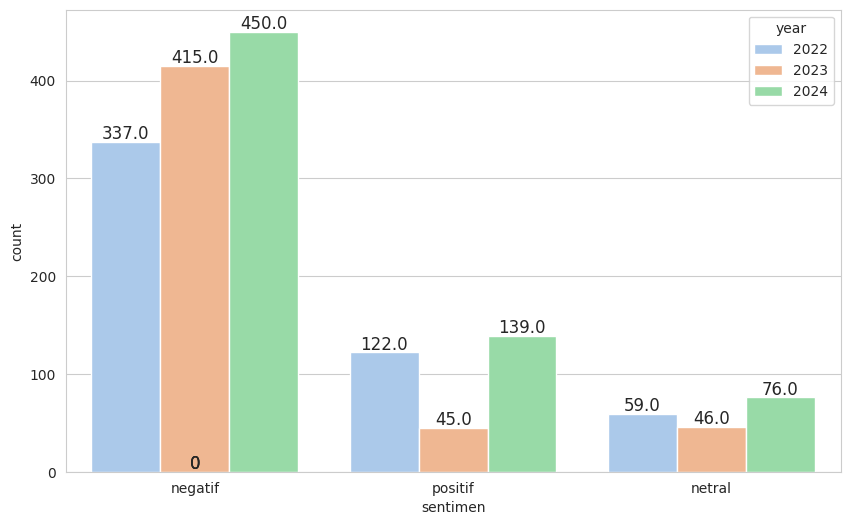

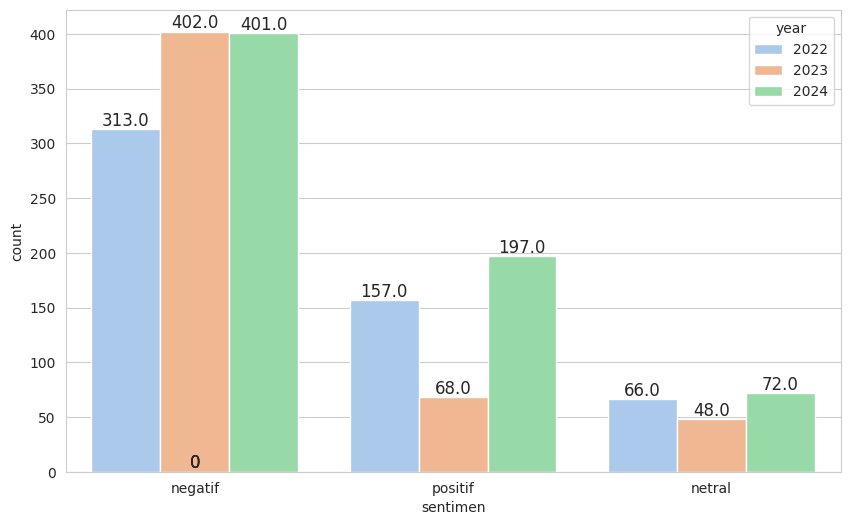

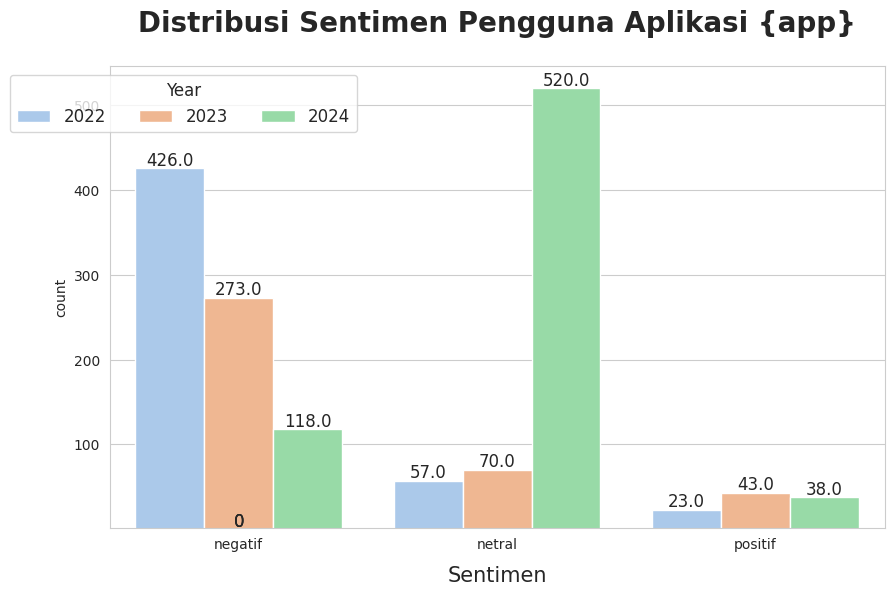

In [ ]:
# Mengonversi kolom 'at' menjadi tipe data datetime untuk mempermudah manipulasi waktu
df['at'] = pd.to_datetime(df['at'])

# Membuat kolom 'year' yang berisi tahun dari tanggal di kolom 'at'
df['year'] = df['at'].dt.year

# Daftar aplikasi yang akan dianalisis
applications = ['BNI', 'BCA', 'BRI']

# Loop untuk memproses setiap aplikasi dalam daftar
for app in applications:
    # Memfilter data hanya untuk aplikasi tertentu
    df_app = df[df['application'] == app]

    # Mendapatkan posisi unik untuk label sentimen (positif, negatif, netral, dll.)
    pasition = range(len(df_app['sentimen'].unique()))
    labels = sorted(df_app['sentimen'].unique())  # Mengurutkan label sentimen secara alfabetis

    # Mengatur gaya visualisasi menggunakan seaborn
    ax = sns.set_style('whitegrid')

    # Membuat ukuran figure agar lebih mudah dibaca
    plt.figure(figsize=(10, 6))

    # Membuat grafik batang untuk menghitung jumlah sentimen berdasarkan tahun
    ax = sns.countplot(x='sentimen', hue='year', data=df_app, palette='pastel')

    # Menambahkan angka di atas setiap batang dalam grafik
    for rect in ax.patches:
        ax.text(rect.get_x() + rect.get_width() / 2,  # Posisi X di tengah batang
                rect.get_height() + 3.25,  # Posisi Y di atas batang
                rect.get_height(),  # Nilai yang ditampilkan (jumlah sentimen)
                horizontalalignment='center', fontsize=12)  # Format teks

# Menambahkan legenda untuk tahun dengan posisi dan ukuran tertentu
plt.legend(fontsize=12, bbox_to_anchor=(0.33,1), ncol=3, title='Year', title_fontsize=12)

# Menambahkan judul grafik (perlu diperbaiki agar `{app}` bisa dinamis)
plt.title(f'Distribusi Sentimen Pengguna Aplikasi {app}', fontsize=20, fontweight='bold', pad=25)

# Memberi label sumbu X dengan teks "Sentimen"
plt.xlabel('Sentimen', fontsize=15, labelpad=10)

# Mengatur label sumbu X agar sesuai dengan kategori sentimen
plt.xticks(pasition, labels)

# Mengatur batas bawah sumbu Y agar tidak nol (untuk estetika)
plt.ylim(1)

# Menampilkan grafik
plt.show()


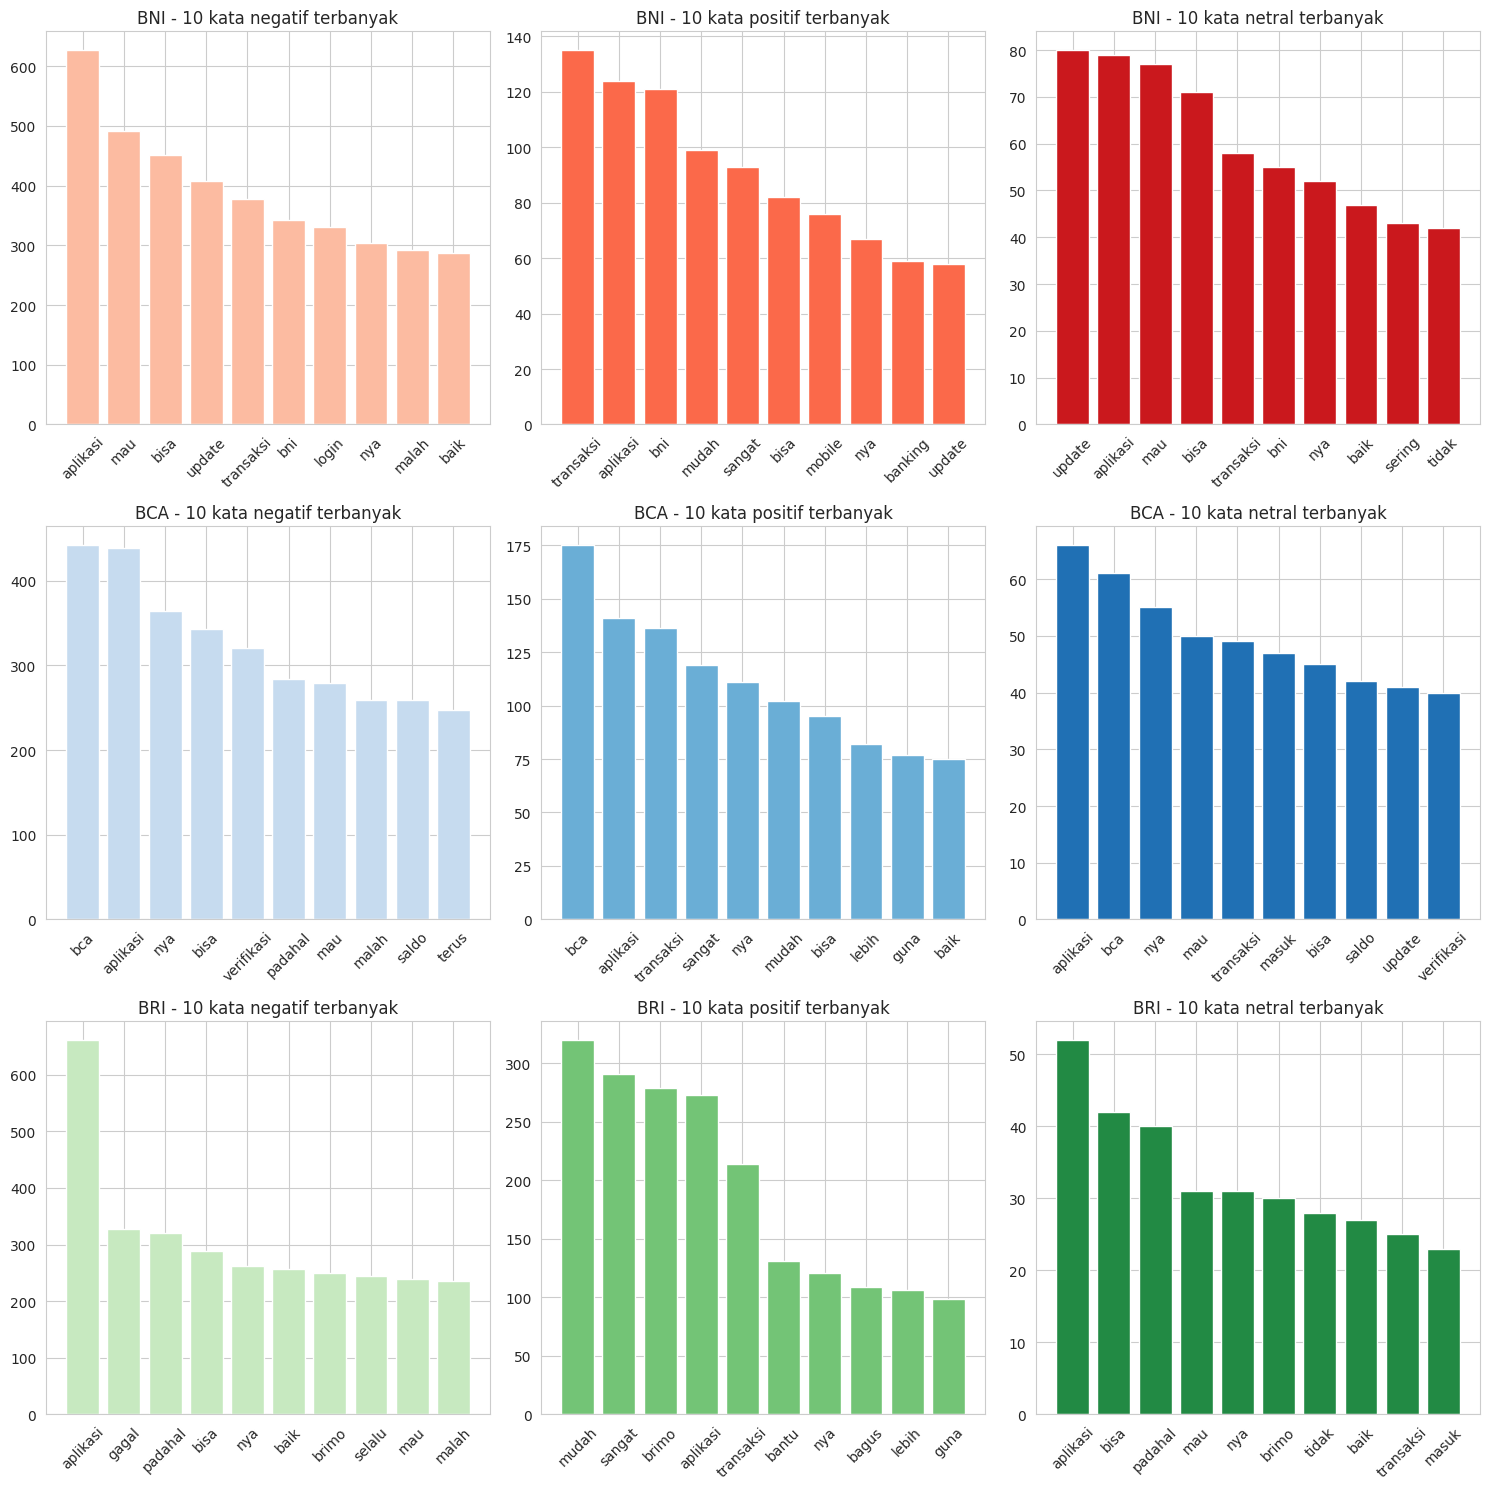

In [ ]:
def hitung_kata_terbanyak(df, aplikasi, sentimen):
    komentar = df[(df['application']== aplikasi) & (df['sentimen']==sentimen)]['content']
    kata_counter = Counter()
    komentar.apply(lambda x: kata_counter.update(x.split()))
    return pd.DataFrame(kata_counter.most_common(10), columns=['Kata','Frekuensi'])

def visualisasi_kata(top_kata_df, judul, warna, posisi):
    plt.subplot(3,3,posisi)
    plt.bar(top_kata_df['Kata'], top_kata_df['Frekuensi'], color=warna)
    plt.title(judul)
    plt.xticks(rotation=45)

aplikasi_list = ['BNI','BCA','BRI']
sentimen_list = ['negatif','positif','netral']

palette = {
    'BNI': sns.color_palette('Reds', 3),
    'BRI': sns.color_palette('Greens', 3),
    'BCA': sns.color_palette('Blues', 3)
}

plt.figure(figsize=(15,15))

posisi = 1
for aplikasi in aplikasi_list:
  for idx, sentimen in enumerate(sentimen_list):
      top_kata_df = hitung_kata_terbanyak(df, aplikasi, sentimen)
      warna = palette[aplikasi][idx]
      judul = f'{aplikasi} - 10 kata {sentimen} terbanyak'
      visualisasi_kata(top_kata_df, judul, warna, posisi)
      posisi += 1

plt.tight_layout()
plt.show()

Prepare data training

In [ ]:
df_bca = df[df['application'] == 'BCA']
df_bni = df[df['application'] == 'BNI']
df_bri = df[df['application'] == 'BRI']

In [ ]:
df_bca

,content,at,userName,score,application,sentimen,year
0,update malah ngabisin pulsa buat verifikasi le...,2022-12-31 15:33:31,Miftah Assundawi,1,BCA,negatif,2022
1,udah scan dokumen sama scan wajah ulang kali t...,2022-12-31 09:31:31,muhamad maulana ahsan,1,BCA,negatif,2022
2,adminnya jawab selalu monoton mohon kirim scre...,2022-12-31 06:42:45,Lanjutkan Di Kita Official,1,BCA,negatif,2022
3,aplikasi jadi guna masa nali wajah milik nya b...,2022-12-31 05:59:59,Beizi Nakata,1,BCA,negatif,2022
4,update malah nyusahinlogin beberapa kali tetep...,2022-12-31 03:45:08,Akhmad Supriyanto,1,BCA,negatif,2022
...,...,...,...,...,...,...,...
1719,bank gila tulis gagal transfer saldo potong 4 ...,2024-09-05 21:12:50,yoga pratama,1,BCA,negatif,2024
1720,paling gampang emang kalo pake bca g ribet mantap,2024-09-05 21:12:49,Yoga Pw,5,BCA,positif,2024
1721,menu edit inbox transfer hilang kembali menu e...,2024-09-05 20:30:01,Ratu Devi Bestari,1,BCA,negatif,2024
1722,aplikasi bisa tambah berani ber hasil,2024-09-05 20:06:22,Made Suherti,4,BCA,positif,2024


In [ ]:
df_bni

,content,at,userName,score,application,sentimen,year
1724,note bni kalo mobile tunai lebih baik usah pak...,2022-12-31 20:50:01,M. Romi Alfianto,1,BNI,negatif,2022
1725,sempat rasa kecewa telah update guna telah uni...,2022-12-31 19:18:10,Bey Dalfir,4,BNI,positif,2022
1726,aplikasi bni mobile ku sekarang lot banget pas...,2022-12-31 13:13:13,babeh adv,3,BNI,netral,2022
1727,hallo aplikasi tidak buka terus apa sistem mai...,2022-12-31 09:00:09,Agus Yudhistira,2,BNI,negatif,2022
1728,makin kesini makin jelas terdetksi dapat aplik...,2022-12-31 01:28:33,Eko Nurbiantoro,1,BNI,negatif,2022
...,...,...,...,...,...,...,...
3408,sangat bantu transaksi uang,2024-09-02 11:21:30,wisnu ardi,5,BNI,positif,2024
3409,dulu sangat kecewa sekatang gilir bgus aman se...,2024-09-02 11:19:21,GALIH SETIAWAN,5,BNI,positif,2024
3410,kalian maintenance aplikasi hari jam kerja ada...,2024-09-02 11:18:41,Bodhi Purwindarto,1,BNI,negatif,2024
3411,aplikasi sering update tidak yang baru mau log...,2024-09-02 11:16:29,Adi Kurniawan Suyud,1,BNI,negatif,2024


In [ ]:
df_bri

,content,at,userName,score,application,sentimen,year
3413,mau transaksi bisa kata hrs update versi baru ...,2022-12-31 16:55:46,icha kindly,1,BRI,negatif,2022
3414,aplikasi kurang bagus masa tari jumlah tari la...,2022-12-31 13:42:20,Amira Eliezer,4,BRI,positif,2022
3415,beberapa bulan terahir fitur tarik tunai tidak...,2022-12-30 08:47:19,Mustagh Firin,2,BRI,negatif,2022
3416,diupdate sekarang malah jadi bisa tarik tunai ...,2022-12-30 05:59:59,Teguh Saputra,1,BRI,negatif,2022
3417,di update transaksi beli pulsa ada masalah bar...,2022-12-30 05:42:58,Anak Golempang,1,BRI,negatif,2022
...,...,...,...,...,...,...,...
4976,bisa dibukadisentuh bisapdahal baru buat brimo...,2024-09-23 19:47:35,Alkarim Sukamti,2,BRI,negatif,2024
4977,sangat bantu mudah guna efesien waktu,2024-09-23 19:41:03,Setya Yiyin,5,BRI,positif,2024
4978,mantapp cepat tepat akurat,2024-09-23 19:27:20,Kristop Hura,5,BRI,positif,2024
4979,sangat mudah guna transasi apa trims brimo,2024-09-23 19:26:09,Oshin Bali,5,BRI,positif,2024


In [ ]:
# memisahakn data traning dan data testing
X_bca = df_bca['content']
y_bca = df_bca['sentimen']

X_bni = df_bni['content']
y_bni = df_bni['sentimen']

X_bri = df_bri['content']
y_bri = df_bri['sentimen']

In [ ]:
X_bri

,content
3413,mau transaksi bisa kata hrs update versi baru ...
3414,aplikasi kurang bagus masa tari jumlah tari la...
3415,beberapa bulan terahir fitur tarik tunai tidak...
3416,diupdate sekarang malah jadi bisa tarik tunai ...
3417,di update transaksi beli pulsa ada masalah bar...
...,...
4976,bisa dibukadisentuh bisapdahal baru buat brimo...
4977,sangat bantu mudah guna efesien waktu
4978,mantapp cepat tepat akurat
4979,sangat mudah guna transasi apa trims brimo


In [ ]:
X_bni

,content
1724,note bni kalo mobile tunai lebih baik usah pak...
1725,sempat rasa kecewa telah update guna telah uni...
1726,aplikasi bni mobile ku sekarang lot banget pas...
1727,hallo aplikasi tidak buka terus apa sistem mai...
1728,makin kesini makin jelas terdetksi dapat aplik...
...,...
3408,sangat bantu transaksi uang
3409,dulu sangat kecewa sekatang gilir bgus aman se...
3410,kalian maintenance aplikasi hari jam kerja ada...
3411,aplikasi sering update tidak yang baru mau log...


In [ ]:
X_bca

,content
0,update malah ngabisin pulsa buat verifikasi le...
1,udah scan dokumen sama scan wajah ulang kali t...
2,adminnya jawab selalu monoton mohon kirim scre...
3,aplikasi jadi guna masa nali wajah milik nya b...
4,update malah nyusahinlogin beberapa kali tetep...
...,...
1719,bank gila tulis gagal transfer saldo potong 4 ...
1720,paling gampang emang kalo pake bca g ribet mantap
1721,menu edit inbox transfer hilang kembali menu e...
1722,aplikasi bisa tambah berani ber hasil


In [ ]:
data = {
    'BCA': (X_bca, y_bca),
    'BNI': (X_bni, y_bni),
    'BRI': (X_bri, y_bri)
}

Traning data

In [ ]:
result = []

for app, (X, y) in data.items():
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

    vectorizer = CountVectorizer()
    x_train_vec = vectorizer.fit_transform(x_train).toarray()
    x_test_vec = vectorizer.transform(x_test).toarray()

    classifier = {
        'KNN' : KNeighborsClassifier(n_neighbors=5),
        'RandomForest': RandomForestClassifier(),
        'NaiveBayes': MultinomialNB(),
        'SVM': SVC()
    }

    for clf_name, clf in classifier.items():
        clf.fit(x_train_vec, y_train)
        y_pred = clf.predict(x_test_vec)

        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        result.append({
            'Application': app,
            'Classifier': clf_name,
            'Accuracy': accuracy,
            'Recall': recall,
            'Precision': precision,
            'F1 Score': f1
        })

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
df_result = pd.DataFrame(result)
df_result

,Application,Classifier,Accuracy,Recall,Precision,F1 Score
0,BCA,KNN,0.613900,0.613900,0.668439,0.612645
1,BCA,RandomForest,0.752896,0.752896,0.679252,0.704481
2,BCA,NaiveBayes,0.733591,0.733591,0.657412,0.689218
3,BCA,SVM,0.737452,0.737452,0.670936,0.681990
4,BNI,KNN,0.586614,0.586614,0.609665,0.574091
5,BNI,RandomForest,0.740157,0.740157,0.648646,0.667190
6,BNI,NaiveBayes,0.724409,0.724409,0.636599,0.648843
7,BNI,SVM,0.724409,0.724409,0.646232,0.642329
8,BRI,KNN,0.474576,0.474576,0.593907,0.355897
9,BRI,RandomForest,0.834746,0.834746,0.815188,0.814441


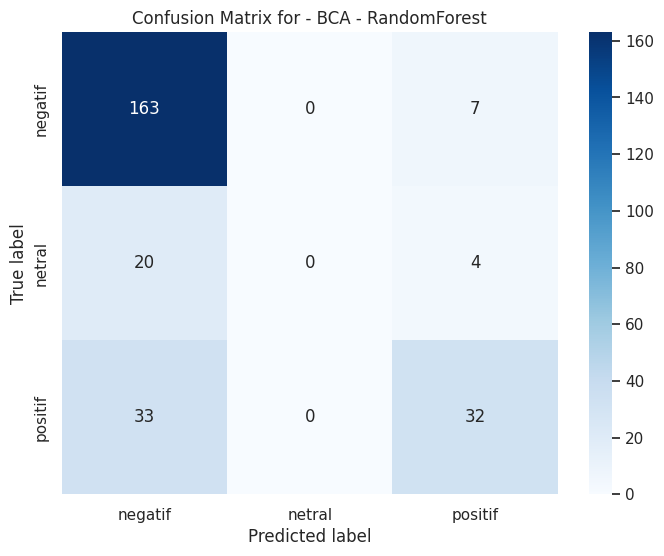

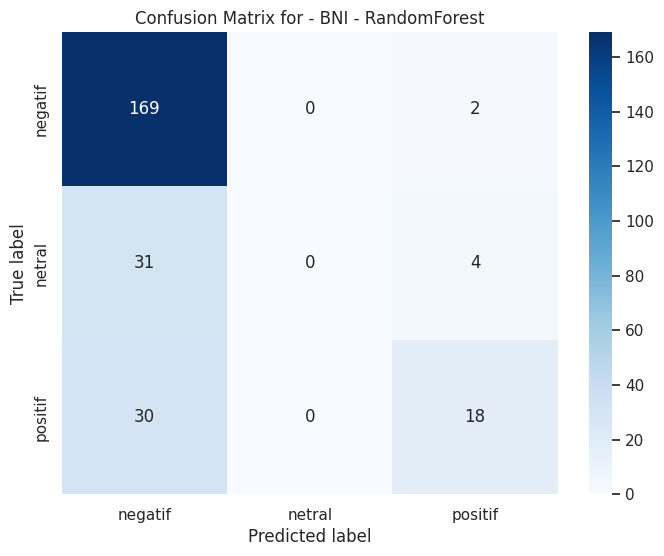

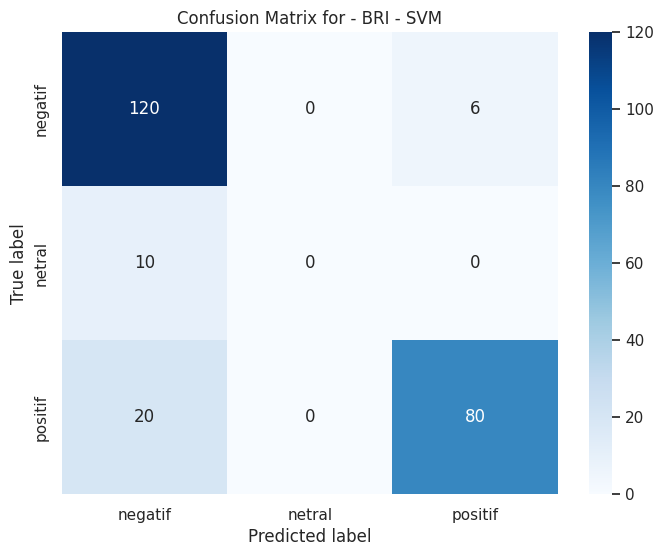

In [ ]:
test_classifiers = df_result.loc[df_result.groupby('Application')['F1 Score'].idxmax()]

for i, row in test_classifiers.iterrows():
    app = row['Application']
    clf_name = row['Classifier']

    x_train, x_test, y_train, y_test = train_test_split(data[app][0], data[app][1], test_size=0.15, random_state=42)
    vectorizer = CountVectorizer()
    x_train_vec = vectorizer.fit_transform(x_train).toarray()
    x_test_vec = vectorizer.transform(x_test).toarray()

    clf = classifier[clf_name]
    clf.fit(x_train_vec, y_train)
    y_pred = clf.predict(x_test_vec)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=np.unique(y_test), yticklabels=np.unique(y_train))
    plt.title(f'Confusion Matrix for - {app} - {clf_name}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

<ipython-input-66-34e847ac39cb>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-66-34e847ac39cb>:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-66-34e847ac39cb>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-66-34e847ac39cb>:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-66-34e847ac39cb

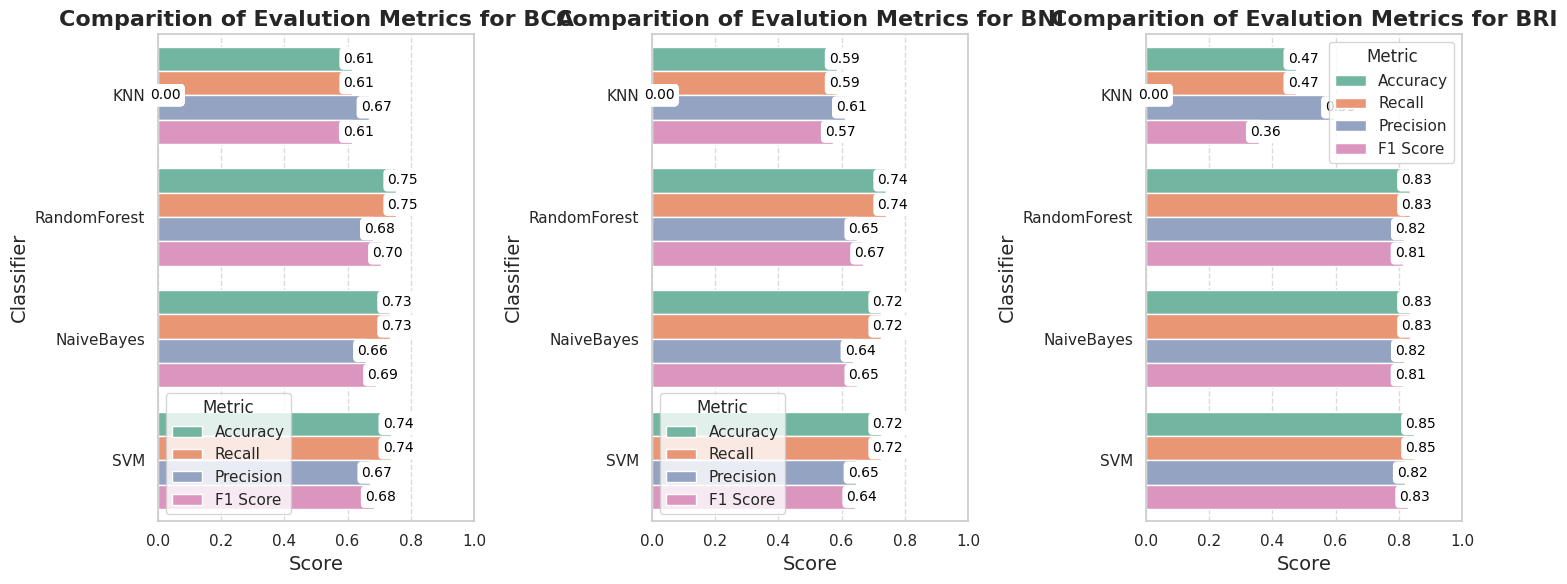

In [ ]:
sns.set(style='whitegrid')
palette = sns.color_palette('Set2')

fig, axs = plt.subplots(1, 3, figsize=(15,6))

applications = df_result['Application'].unique()

for ax, app in zip(axs, applications):
    app_results = df_result[df_result['Application'] == app]
    # Changed value_vars to include the actual column names
    app_results_method = app_results.melt(id_vars=['Application','Classifier'],
                                        value_vars=['Accuracy', 'Recall', 'Precision','F1 Score'],
                                        var_name='Metric', value_name='Value')
    # Changed x to 'Value' to use the actual column name for score values
    sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)

    ax.set_title(f'Comparition of Evalution Metrics for {app}', fontsize=16, weight='bold')
    ax.set_xlabel('Score',fontsize=14)
    ax.set_ylabel('Classifier', fontsize=14)
    ax.set_xlim(0,1)
    ax.tick_params(axis='y', rotation=0)

    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    for p in ax.patches:
        score = p.get_width()
        ax.annotate(f'{score:.2f}',
                    (score, p.get_y() + p.get_height() / 2),
                    ha='center', va='center',
                    color='black', fontsize=10,
                    xytext=(5,0),
                    textcoords='offset points',
                    bbox=dict(facecolor='white', edgecolor='none',boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

<ipython-input-67-1a01e8f669d4>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-67-1a01e8f669d4>:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-67-1a01e8f669d4>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-67-1a01e8f669d4>:15: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)
<ipython-input-67-1a01e8f669d4

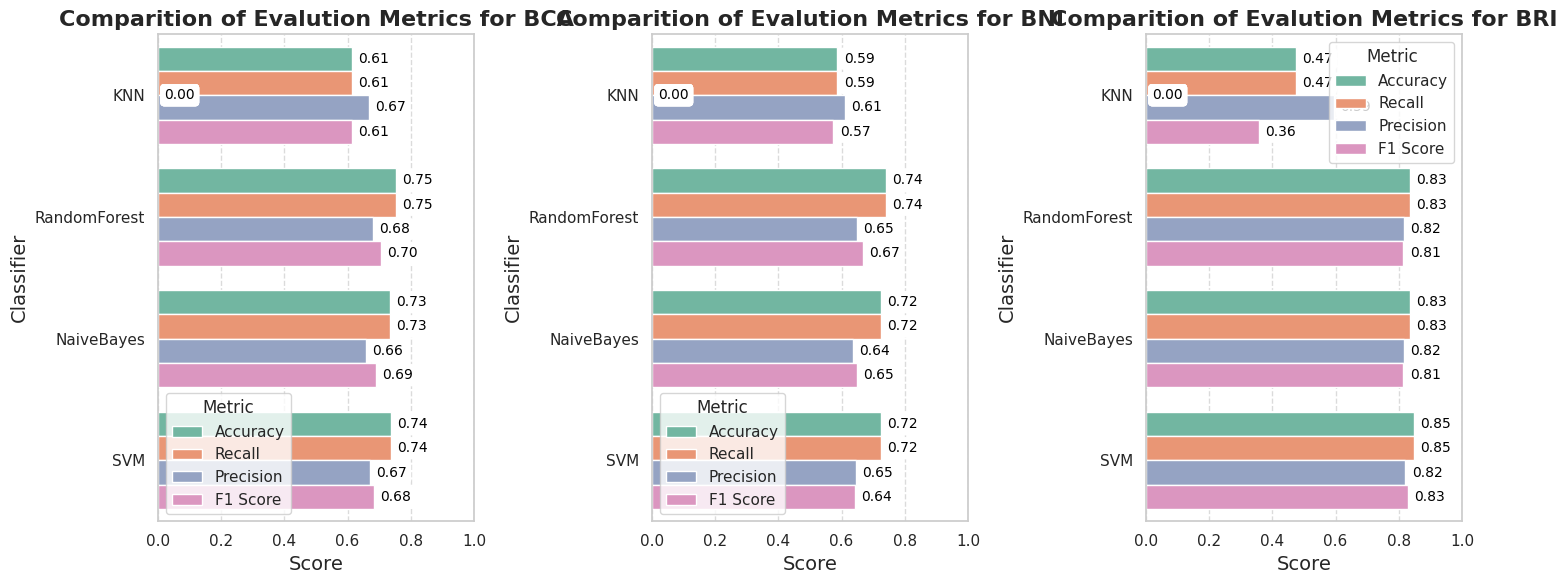

In [ ]:
sns.set(style='whitegrid')
palette = sns.color_palette('Set2')

fig, axs = plt.subplots(1, 3, figsize=(15,6))

applications = df_result['Application'].unique()

for ax, app in zip(axs, applications):
    app_results = df_result[df_result['Application'] == app]
    # Changed value_vars to include the actual column names
    app_results_method = app_results.melt(id_vars=['Application','Classifier'],
                                        value_vars=['Accuracy', 'Recall', 'Precision','F1 Score'],
                                        var_name='Metric', value_name='Value')
    # Changed x to 'Value' to use the actual column name for score values
    sns.barplot(data=app_results_method, x='Value', y='Classifier', hue='Metric', ax=ax, ci=None, palette=palette)

    ax.set_title(f'Comparition of Evalution Metrics for {app}', fontsize=16, weight='bold')
    ax.set_xlabel('Score',fontsize=14)
    ax.set_ylabel('Classifier', fontsize=14)
    ax.set_xlim(0,1)
    ax.tick_params(axis='y', rotation=0)

    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    for p in ax.patches:
        score = p.get_width()
        # Changed xytext and textcoords to position annotations relative to data
        ax.annotate(f'{score:.2f}',
                    (score + 0.02, p.get_y() + p.get_height() / 2),  # Adjust 0.02 for spacing
                    ha='left', va='center',  # Align left and center vertically
                    color='black', fontsize=10,
                    # Removed xytext and textcoords
                    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))  # Changed boxstyle

plt.tight_layout()
plt.show()